# CISC372 Final Project: Shoulder Impants X-Ray Manufacturer Classification

![img](https://www.queensu.ca/sites/default/files/assets/pages/QueensLogo_colour.png)

Author: Meng(Simon) Zhou, Shanglin(Marcus) Mo

Email: simon.zhou@queensu.ca, shanglin.mo@queensu.ca


## Loading Packages:

In [ ]:
# packages
import collections
from PIL import Image
import pandas as pd
from tqdm.notebook import tqdm
import os
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Conv2D, Flatten, Dense, Dropout, Input, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50
from keras.applications.inception_v3 import InceptionV3
import keras.backend as K
from keras.callbacks import Callback
import datetime
import cv2
from google.colab.patches import cv2_imshow
import numpy as np
import io
from skimage.transform import resize
from skimage import color
from skimage import io
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from tensorflow.keras.layers.experimental.preprocessing import CenterCrop
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.utils import class_weight
from sklearn.metrics import plot_confusion_matrix
import imgaug.augmenters as im_aug
%matplotlib inline
print("finish loading!")

finish loading!


### Data Loading method:

In [ ]:
from google.colab import drive # get the access from google drive
drive.mount('/content/drive/')

Mounted at /content/drive/


## Raw data preprocess


In [ ]:
# Set the right path to the data
path_var = '/content/drive/MyDrive/data/' 
#count the number of images in the folder
path, dirs, files = next(os.walk(path_var))
number_images = len(files)

In [ ]:
# convert real image to numpy array
images = np.ndarray(shape = (number_images, 256,256,3), dtype = np.float32) # load image in the standard format
labels = np.ndarray(shape = (number_images)) # store labels
image_names = [] # store image name

i = 0
# Loop through all files in folder, grabbing labels and images
for file in os.listdir(path_var):
  if file.split('.')[0] == 'Cofield':
    labels[i] = 0
  elif file.split('.')[0] == 'Depuy':
    labels[i] = 1
  elif file.split('.')[0] == 'Tornier':
    labels[i] = 2
  elif file.split('.')[0] == 'Zimmer':
    labels[i] = 3
  #read in the image
  pic = plt.imread(path_var + file,format='jpg') #　format rgb
  #resize the image to the standard dimension
  pic = resize(pic,(256,256,3))
  images[i] = pic # store raw image
  image_names.append(file)
  i += 1

name_map = collections.defaultdict()
name_map[0] = 'Cofield'
name_map[1] = 'Depuy'
name_map[2] = 'Tornier'
name_map[3] = 'Zimmer'



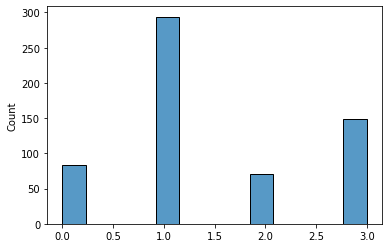

In [ ]:
sns.histplot(labels)

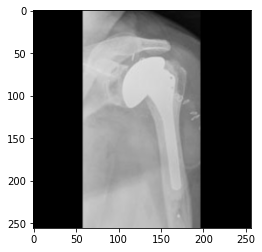

Tornier


In [ ]:
plt.imshow(images[1])
plt.show()
print(name_map[labels[1]])

In [ ]:
labels[:10]

array([3., 2., 1., 3., 3., 0., 3., 1., 1., 2.])

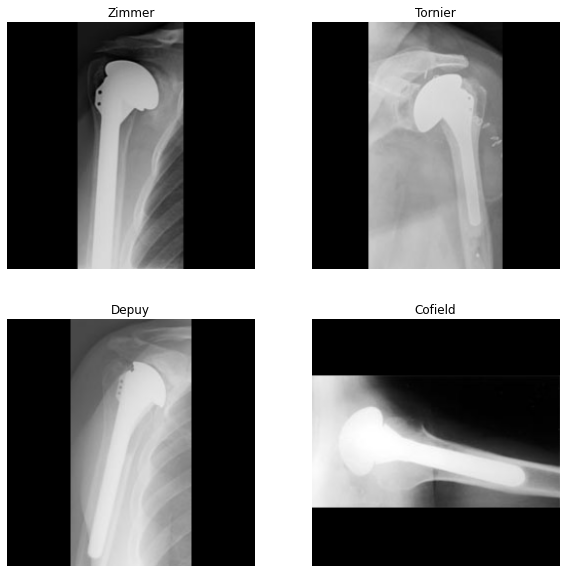

In [ ]:
indx = [0,1,2,3] # take four images from different class for visualization
class_label = [0,1,2,5]
index_map = dict(zip(indx, class_label))

plt.figure(figsize=(10, 10))
for i in range(0,4):
  ax = plt.subplot(2, 2, i%4+1)
  plt.imshow(images[index_map[i]])
  plt.title(name_map[int(labels[class_label[i]])])
  plt.axis("off")


In [ ]:
path_var_new = '/content/drive/MyDrive/project_data/' 
np.save(path_var_new + 'images_origin', images)
np.save(path_var_new + 'labels',labels)
np.save(path_var_new + 'image_names',np.asarray(image_names))

## Augmentation on training dataset

We only take 447 images for augmentation, the remaining 150 images are for the final test data. This is risky because we do not have much images per class, the seperation of 150 images may result in low accuracy than use the full dataset

### Spliting data 

In [ ]:
path_var = '/content/drive/MyDrive/data/'
#count the number of images in the folder
path, dirs, files = next(os.walk(path_var))
number_images = len(files)

In [ ]:
import random
random.seed(123)
test_ind = random.sample(range(0,597),150)
print(test_ind)

[53, 274, 89, 417, 272, 110, 39, 388, 549, 575, 340, 348, 596, 163, 138, 345, 574, 341, 251, 167, 1, 446, 594, 386, 71, 6, 323, 459, 104, 44, 94, 145, 129, 21, 298, 440, 488, 271, 480, 37, 312, 351, 534, 494, 211, 539, 322, 12, 407, 525, 444, 497, 533, 429, 383, 522, 32, 185, 84, 498, 268, 174, 342, 581, 400, 75, 467, 396, 344, 16, 193, 90, 372, 13, 360, 234, 415, 513, 61, 294, 506, 238, 495, 181, 157, 455, 526, 384, 236, 22, 5, 68, 233, 98, 10, 131, 409, 180, 350, 139, 560, 222, 324, 215, 0, 55, 316, 540, 261, 519, 362, 45, 42, 221, 569, 4, 548, 595, 510, 557, 279, 355, 325, 206, 14, 165, 134, 241, 527, 509, 287, 171, 212, 178, 588, 327, 474, 83, 452, 214, 489, 367, 445, 347, 73, 190, 554, 120, 380, 40]


In [ ]:
test_data_file = []
for i in range(len(test_ind)):
  test_data_file.append(files[test_ind[i]])

test_data_file

['Depuy.68.jpg',
 'Cofield.80.jpg',
 'Cofield.72.jpg',
 'Depuy.176.jpg',
 'Depuy.289.jpg',
 'Depuy.67.jpg',
 'Depuy.60.jpg',
 'Zimmer.4.jpg',
 'Zimmer.79.jpg',
 'Cofield.15.jpg',
 'Depuy.74.jpg',
 'Depuy.128.jpg',
 'Zimmer.111.jpg',
 'Depuy.76.jpg',
 'Depuy.24.jpg',
 'Depuy.29.jpg',
 'Zimmer.115.jpg',
 'Depuy.181.jpg',
 'Depuy.243.jpg',
 'Depuy.210.jpg',
 'Tornier.56.jpg',
 'Zimmer.29.jpg',
 'Depuy.279.jpg',
 'Tornier.22.jpg',
 'Depuy.122.jpg',
 'Zimmer.140.jpg',
 'Cofield.86.jpg',
 'Zimmer.21.jpg',
 'Zimmer.149.jpg',
 'Zimmer.117.jpg',
 'Zimmer.145.jpg',
 'Depuy.116.jpg',
 'Tornier.25.jpg',
 'Depuy.137.jpg',
 'Cofield.56.jpg',
 'Tornier.31.jpg',
 'Zimmer.56.jpg',
 'Depuy.189.jpg',
 'Depuy.73.jpg',
 'Zimmer.14.jpg',
 'Cofield.21.jpg',
 'Cofield.7.jpg',
 'Depuy.75.jpg',
 'Depuy.220.jpg',
 'Tornier.8.jpg',
 'Depuy.159.jpg',
 'Depuy.263.jpg',
 'Zimmer.17.jpg',
 'Depuy.282.jpg',
 'Depuy.87.jpg',
 'Tornier.6.jpg',
 'Depuy.236.jpg',
 'Zimmer.90.jpg',
 'Depuy.164.jpg',
 'Tornier.64.jpg',
 'De

In [ ]:
train_data_file = []
for i in range(len(files)):
  if files[i] not in test_data_file:
    train_data_file.append(files[i])
  else:
    continue
train_data_file

['Depuy.25.jpg',
 'Zimmer.76.jpg',
 'Depuy.95.jpg',
 'Depuy.52.jpg',
 'Tornier.48.jpg',
 'Depuy.136.jpg',
 'Tornier.44.jpg',
 'Depuy.1.jpg',
 'Depuy.209.jpg',
 'Zimmer.124.jpg',
 'Depuy.283.jpg',
 'Zimmer.107.jpg',
 'Depuy.57.jpg',
 'Zimmer.28.jpg',
 'Cofield.12.jpg',
 'Depuy.83.jpg',
 'Depuy.216.jpg',
 'Depuy.15.jpg',
 'Depuy.169.jpg',
 'Depuy.120.jpg',
 'Depuy.257.jpg',
 'Depuy.88.jpg',
 'Depuy.79.jpg',
 'Tornier.3.jpg',
 'Depuy.123.jpg',
 'Zimmer.104.jpg',
 'Tornier.43.jpg',
 'Depuy.256.jpg',
 'Depuy.100.jpg',
 'Zimmer.134.jpg',
 'Tornier.61.jpg',
 'Depuy.212.jpg',
 'Depuy.168.jpg',
 'Tornier.23.jpg',
 'Depuy.121.jpg',
 'Cofield.9.jpg',
 'Depuy.109.jpg',
 'Zimmer.40.jpg',
 'Depuy.124.jpg',
 'Depuy.112.jpg',
 'Depuy.239.jpg',
 'Tornier.52.jpg',
 'Cofield.22.jpg',
 'Zimmer.123.jpg',
 'Zimmer.63.jpg',
 'Depuy.200.jpg',
 'Zimmer.34.jpg',
 'Depuy.115.jpg',
 'Tornier.27.jpg',
 'Depuy.278.jpg',
 'Depuy.18.jpg',
 'Cofield.49.jpg',
 'Depuy.288.jpg',
 'Tornier.68.jpg',
 'Depuy.141.jpg',
 'Tor

In [ ]:
# save file
path_var_new = '/content/drive/MyDrive/project_data/'
np.save(path_var_new + 'train_file_aug', train_data_file)
np.save(path_var_new + 'test_file_aug', test_data_file)

### Augmentation

In [ ]:
path_var = '/content/drive/MyDrive/data/'
path_var_new = '/content/drive/MyDrive/data/'
train_aug = np.load(path_var_new + 'train_file_aug.npy')
test_aug = np.load(path_var_new + 'test_file_aug.npy')

In [ ]:
test_pic = plt.imread(path_var + 'Cofield.57.jpg')
test_pic = resize(test_pic,(256,256,3)).astype(np.float32)
#plt.imshow(test_pic)
test_pic.dtype

dtype('float32')

In [ ]:
#path_var = '/content/drive/MyDrive/data/'
number_images = len(train_aug)

# eight additional augmented images  
images = np.ndarray(shape = (number_images*9, 256,256,3), dtype = np.float32)
labels = np.ndarray(shape = (number_images*9))
# lets store the names of the images as well
image_names = []

# Image Augmentation

# apply a rotation on each image.
rotate = im_aug.Affine(rotate=(0, 360)) # 0~360 degree random rotation

# apply a translation on each image.
translate = im_aug.Affine(translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)}) # translate on x and y axis independently for up tp 20% shift

# introduce image distortion of random angle between -30 degreee and 30 degree 
shear = im_aug.Affine(shear=(-30,30))

# Apply a scaling on each image to enlarge it, make important features more noticable
scaling = im_aug.Affine(scale=(1.05,2)) # zoom all image in all direction

# Apply a cropping to each image. Random crop 10% to 25% of the image
cropping = im_aug.size.Crop(percent=(0.10, 0.25))

# Flip the image horizontally with probability = 1
flip_lr = im_aug.Fliplr(p=1.0)

# Flip the image vertically with probability = 1
flip_ud = im_aug.Flipud(p=1.0)

# introduce random white noise to the image with mean = 0, std = 1.1
noise = im_aug.AdditiveGaussianNoise(loc=0, scale=(0, 1.1), per_channel=0.5)



i = 0;
# Looping through all files in folder
for file in os.listdir(path_var):
  if file in train_aug: # if the image is selected to be train augmented data
  # apply augmentation
    label = 0
    if file.split('.')[0] == 'Cofield':
      label = 0
    elif file.split('.')[0] == 'Depuy':
      label = 1
    elif file.split('.')[0] == 'Tornier':
      label = 2
    elif file.split('.')[0] == 'Zimmer':
      label = 3
    #read in the image
    pic = plt.imread(path_var + file, format='jpg')
    #resize the image to the standard dimension
    pic = resize(pic,(256,256,3)).astype(np.float32)

    # 1
    images[i] = pic # original image
    labels[i] = label
    image_names.append(file)
    i += 1

    # 2
    rotate_im = rotate.augment_image(pic)
    images[i] = rotate_im
    labels[i] = label
    i += 1

    # 3
    translate_im = translate.augment_image(pic)
    images[i] = translate_im
    labels[i] = label
    i += 1

    # 4
    shear_im = shear.augment_image(pic)
    images[i] = shear_im
    labels[i] = label
    i += 1

    # 5
    scaling_im = scaling.augment_image(pic)
    images[i] = scaling_im
    labels[i] = label
    i += 1

    # 6
    cropping_im = cropping.augment_image(pic)
    images[i] = cropping_im
    labels[i] = label
    i += 1

    # 7
    flip_lr_im = flip_lr.augment_image(pic)
    images[i] = flip_lr_im
    labels[i] = label
    i += 1

    # 8
    flip_ud_im = flip_ud.augment_image(pic)
    images[i] = flip_ud_im
    labels[i] = label
    i += 1

    # 9
    noise_im = noise.augment_image(pic)
    images[i] = noise_im
    labels[i] = label
    i += 1
  
  else: # if the image is selected to be test data, do nothing
    continue

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


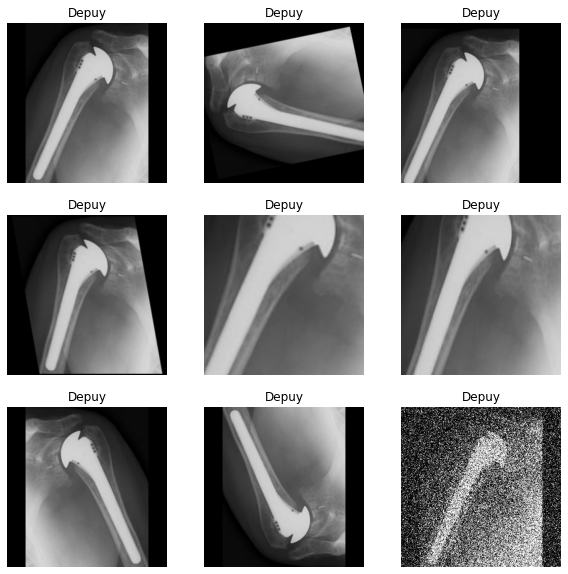

In [ ]:
plt.figure(figsize=(10, 10))
for i in range(27,36):
  ax = plt.subplot(3, 3, i%9 + 1)
  plt.imshow(images[i])
  plt.title(name_map[int(labels[i])])
  plt.axis("off")

In [ ]:
# save file
np.save(path_var_new + 'images_augmented.npy', images)
np.save(path_var_new + 'labels_augmented.npy', labels)

### Alternative Way of Augmentation (reduce half of the size of original aug.)

In [ ]:
path_var = '/content/drive/MyDrive/data/'
path_var_new = '/content/drive/MyDrive/project_data/'
train_aug = np.load(path_var_new + 'train_file_aug.npy')

In [ ]:
#path_var = '/content/drive/MyDrive/data/'
number_images = len(train_aug)

# lets try to load in our data 
images = np.ndarray(shape = (number_images*5, 256,256,3), dtype = np.float32)
labels = np.ndarray(shape = (number_images*5))
# lets store the names of the images as well 
image_names = []

# Image Augmentation
# Apply a rotation on each image.
rotate = im_aug.Affine(rotate=(0, 360)) # 360 degree rotation

scaling = im_aug.Affine(scale=(1.05,2)) # zoom all image(direction) on both x and y axis

cropping = im_aug.size.Crop(percent=(0.10, 0.20)) # crop image randomly for 10% to 25%

flip_lr = im_aug.Fliplr(p=1.0) # flip image horizontally with probability = 1



i = 0;
# Looping through all files in folder
for file in os.listdir(path_var):
  if file in train_aug: # same strategy as previous section
    label = 0
    if file.split('.')[0] == 'Cofield':
      label = 0
    elif file.split('.')[0] == 'Depuy':
      label = 1
    elif file.split('.')[0] == 'Tornier':
      label = 2
    elif file.split('.')[0] == 'Zimmer':
      label = 3
    #read in the image
    pic = plt.imread(path_var + file, format='jpg')
    #resize the image to the standard dimension
    pic = resize(pic,(256,256,3)).astype(np.float32)

    images[i] = pic # original image
    labels[i] = label
    image_names.append(file)
    i += 1

    rotate_im = rotate.augment_image(pic)
    images[i] = rotate_im
    labels[i] = label
    i += 1

    scaling_im = scaling.augment_image(pic)
    images[i] = scaling_im
    labels[i] = label
    i += 1

    cropping_im = cropping.augment_image(pic)
    images[i] = cropping_im
    labels[i] = label
    i += 1

    flip_lr_im = flip_lr.augment_image(pic)
    images[i] = flip_lr_im
    labels[i] = label
    i += 1

  else:
    continue

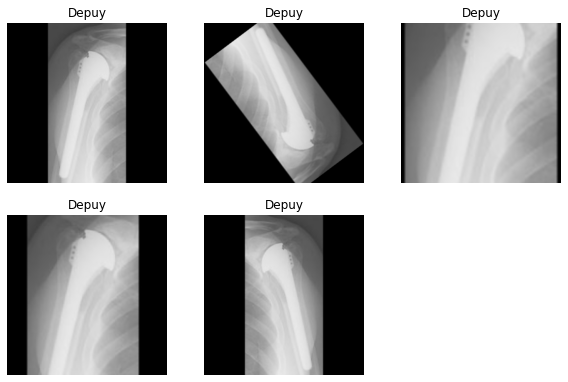

In [ ]:
plt.figure(figsize=(10, 10))
for i in range(0,5):
  ax = plt.subplot(3, 3, i%5 + 1)
  plt.imshow(images[i])
  plt.title(name_map[int(labels[i])])
  plt.axis("off")

In [ ]:
print(images.shape, labels.shape) # now there are only around 2000 images

(2235, 256, 256, 3) (2235,)


In [ ]:
# save file
np.save(path_var_new + 'images_augmented_half.npy', images)
np.save(path_var_new + 'labels_augmented_half.npy', labels)

## Non NN Model w/o Data Aug.

### Random Forest

In [ ]:
path_var = '/content/drive/MyDrive/data/' 
images = np.load(path_var + 'images_origin.npy') # read data
labels = np.load(path_var + 'labels.npy')
image_names = np.load(path_var + 'image_names.npy')

In [ ]:
def print_results(results): # function for print hyperparameter value and model accuracy
    print('BEST PARAMS: {}\n'.format(results.best_params_))

    means = results.cv_results_['mean_test_score']
    stds = results.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, results.cv_results_['params']):
        print('{} (+/-{}) for {}'.format(round(mean, 3), round(std * 2, 3), params))

In [ ]:
num_img, xdim, ydim, channel = images.shape
x_nonNN = images.reshape((num_img, xdim * ydim * channel)) # reshape to 2d array

In [ ]:
x_nonNN_train, x_nonNN_valid, y_nonNN_train, y_nonNN_valid = train_test_split(x_nonNN, labels, stratify = labels) # keep the balance of the data (class weight)
print(x_nonNN_train.shape, y_nonNN_train.shape)
print(x_nonNN_valid.shape, y_nonNN_valid.shape)

(447, 196608) (447,)
(150, 196608) (150,)


In [ ]:
rfcl = RandomForestClassifier(criterion="entropy")
parameters = {
    'n_estimators': [300, 500],
    'max_features': [3, 5, 7],
    'min_samples_leaf': [1, 3, 5]
}

rf_cv = RandomizedSearchCV(rfcl, parameters, verbose = 3, cv = 5)
rf_cv.fit(x_nonNN_train, y_nonNN_train)

print_results(rf_cv)

y_pred = rf_cv.predict(x_nonNN_valid)
print("The confusion matrix is: ")
print(confusion_matrix(y_nonNN_valid, y_pred))

precision, recall, f1, support = precision_recall_fscore_support(y_nonNN_valid, y_pred, average='macro')
print("precision score: %.2f" % (precision))
print("recall score: %.2f" % (recall))
print("f1 score: %.2f" % (f1))


Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] n_estimators=500, min_samples_leaf=1, max_features=5 ............


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  n_estimators=500, min_samples_leaf=1, max_features=5, score=0.578, total=   1.9s
[CV] n_estimators=500, min_samples_leaf=1, max_features=5 ............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.9s remaining:    0.0s


[CV]  n_estimators=500, min_samples_leaf=1, max_features=5, score=0.522, total=   1.9s
[CV] n_estimators=500, min_samples_leaf=1, max_features=5 ............


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.8s remaining:    0.0s


[CV]  n_estimators=500, min_samples_leaf=1, max_features=5, score=0.573, total=   1.9s
[CV] n_estimators=500, min_samples_leaf=1, max_features=5 ............
[CV]  n_estimators=500, min_samples_leaf=1, max_features=5, score=0.573, total=   1.8s
[CV] n_estimators=500, min_samples_leaf=1, max_features=5 ............
[CV]  n_estimators=500, min_samples_leaf=1, max_features=5, score=0.596, total=   1.8s
[CV] n_estimators=300, min_samples_leaf=1, max_features=5 ............
[CV]  n_estimators=300, min_samples_leaf=1, max_features=5, score=0.556, total=   1.2s
[CV] n_estimators=300, min_samples_leaf=1, max_features=5 ............
[CV]  n_estimators=300, min_samples_leaf=1, max_features=5, score=0.533, total=   1.2s
[CV] n_estimators=300, min_samples_leaf=1, max_features=5 ............
[CV]  n_estimators=300, min_samples_leaf=1, max_features=5, score=0.562, total=   1.2s
[CV] n_estimators=300, min_samples_leaf=1, max_features=5 ............
[CV]  n_estimators=300, min_samples_leaf=1, max_feat

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  1.2min finished


BEST PARAMS: {'n_estimators': 500, 'min_samples_leaf': 1, 'max_features': 3}

0.568 (+/-0.049) for {'n_estimators': 500, 'min_samples_leaf': 1, 'max_features': 5}
0.568 (+/-0.048) for {'n_estimators': 300, 'min_samples_leaf': 1, 'max_features': 5}
0.55 (+/-0.03) for {'n_estimators': 300, 'min_samples_leaf': 3, 'max_features': 5}
0.546 (+/-0.064) for {'n_estimators': 500, 'min_samples_leaf': 5, 'max_features': 3}
0.58 (+/-0.056) for {'n_estimators': 500, 'min_samples_leaf': 1, 'max_features': 3}
0.557 (+/-0.046) for {'n_estimators': 500, 'min_samples_leaf': 3, 'max_features': 5}
0.548 (+/-0.042) for {'n_estimators': 500, 'min_samples_leaf': 3, 'max_features': 7}
0.553 (+/-0.044) for {'n_estimators': 300, 'min_samples_leaf': 3, 'max_features': 7}
0.564 (+/-0.049) for {'n_estimators': 300, 'min_samples_leaf': 1, 'max_features': 7}
0.541 (+/-0.054) for {'n_estimators': 300, 'min_samples_leaf': 3, 'max_features': 3}
The confusion matrix is: 
[[ 4 15  1  1]
 [ 1 65  1  7]
 [ 1 13  1  3]
 [ 0

### KNN

In [ ]:
knncl = KNeighborsClassifier(n_neighbors=30, p=2)
# use euclidean distance
# parameters = {
#   'n_neighbors': [30, 35, 40],
#  'weights': ["uniform", "distance"],
#}

#knn_cv = RandomizedSearchCV(knncl, parameters, verbose = 3, cv = 5)
knncl.fit(x_nonNN_train, y_nonNN_train)

#print_results(knncl)

y_pred=knncl.predict(x_nonNN_valid)
print("The confusion matrix is: ")
print(confusion_matrix(y_nonNN_valid,y_pred))

precision,recall,f1,support=precision_recall_fscore_support(y_nonNN_valid,y_pred, average='macro')
accuracy=accuracy_score(y_nonNN_valid, y_pred)
print(accuracy)

The confusion matrix is: 
[[ 1 19  0  1]
 [ 0 71  0  3]
 [ 1 15  0  2]
 [ 0 30  0  7]]
0.5266666666666666


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Non NN Model with Data Aug.

### Random Forest:

In [ ]:
path_var = '/content/drive/MyDrive/data/'
path_var_new = '/content/drive/MyDrive/project_data/'
train_aug = np.load(path_var_new + 'images_augmented.npy')
train_label = np.load(path_var_new + 'labels_augmented.npy')
test_aug = np.load(path_var_new + 'test_for_aug.npy')
test_labels = np.load(path_var_new + 'test_label_for_aug.npy')

In [ ]:
train_img, xdim, ydim, channel = train_aug.shape
train_img_aug = train_aug.reshape((train_img, xdim * ydim * channel))
print(train_img_aug.shape)

(4023, 196608)


In [ ]:
test_num, xdimT, ydimT, channelT = test_aug.shape
test_img_aug = test_aug.reshape((test_num, xdimT * ydimT * channelT))
print(test_img_aug.shape)

(150, 196608)


In [ ]:
rfcl = RandomForestClassifier(criterion="entropy")
parameters = {
    'n_estimators': [300, 500],
    'max_features': [10, 15, 20],
    'min_samples_leaf': [5, 7, 10]
}

rf_cv = RandomizedSearchCV(rfcl, parameters, verbose = 3, cv = 5)
rf_cv.fit(train_img_aug, train_label)

print_results(rf_cv)

y_pred = rf_cv.predict(test_img_aug)
print("The confusion matrix is: ")
print(confusion_matrix(test_labels, y_pred))

precision, recall, f1, support = precision_recall_fscore_support(test_labels, y_pred, average='macro')
print("precision score: %.2f" % (precision))
print("recall score: %.2f" % (recall))
print("f1 score: %.2f" % (f1))

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] n_estimators=500, min_samples_leaf=10, max_features=15 ..........


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  n_estimators=500, min_samples_leaf=10, max_features=15, score=0.539, total=  33.0s
[CV] n_estimators=500, min_samples_leaf=10, max_features=15 ..........


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   33.0s remaining:    0.0s


[CV]  n_estimators=500, min_samples_leaf=10, max_features=15, score=0.506, total=  33.5s
[CV] n_estimators=500, min_samples_leaf=10, max_features=15 ..........


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.1min remaining:    0.0s


[CV]  n_estimators=500, min_samples_leaf=10, max_features=15, score=0.530, total=  34.3s
[CV] n_estimators=500, min_samples_leaf=10, max_features=15 ..........
[CV]  n_estimators=500, min_samples_leaf=10, max_features=15, score=0.519, total=  34.3s
[CV] n_estimators=500, min_samples_leaf=10, max_features=15 ..........
[CV]  n_estimators=500, min_samples_leaf=10, max_features=15, score=0.534, total=  33.4s
[CV] n_estimators=300, min_samples_leaf=10, max_features=15 ..........
[CV]  n_estimators=300, min_samples_leaf=10, max_features=15, score=0.540, total=  23.0s
[CV] n_estimators=300, min_samples_leaf=10, max_features=15 ..........
[CV]  n_estimators=300, min_samples_leaf=10, max_features=15, score=0.506, total=  22.4s
[CV] n_estimators=300, min_samples_leaf=10, max_features=15 ..........
[CV]  n_estimators=300, min_samples_leaf=10, max_features=15, score=0.530, total=  22.9s
[CV] n_estimators=300, min_samples_leaf=10, max_features=15 ..........
[CV]  n_estimators=300, min_samples_leaf

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed: 26.3min finished


BEST PARAMS: {'n_estimators': 300, 'min_samples_leaf': 7, 'max_features': 20}

0.525 (+/-0.024) for {'n_estimators': 500, 'min_samples_leaf': 10, 'max_features': 15}
0.527 (+/-0.024) for {'n_estimators': 300, 'min_samples_leaf': 10, 'max_features': 15}
0.527 (+/-0.027) for {'n_estimators': 300, 'min_samples_leaf': 5, 'max_features': 20}
0.533 (+/-0.024) for {'n_estimators': 300, 'min_samples_leaf': 7, 'max_features': 20}
0.525 (+/-0.018) for {'n_estimators': 300, 'min_samples_leaf': 10, 'max_features': 10}
0.525 (+/-0.024) for {'n_estimators': 300, 'min_samples_leaf': 5, 'max_features': 15}
0.528 (+/-0.02) for {'n_estimators': 300, 'min_samples_leaf': 7, 'max_features': 15}
0.53 (+/-0.027) for {'n_estimators': 500, 'min_samples_leaf': 7, 'max_features': 20}
0.527 (+/-0.029) for {'n_estimators': 500, 'min_samples_leaf': 7, 'max_features': 15}
0.53 (+/-0.03) for {'n_estimators': 500, 'min_samples_leaf': 5, 'max_features': 20}
The confusion matrix is: 
[[ 8 17  0  3]
 [ 2 56  0  7]
 [ 1 1

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### KNN

In [ ]:
train_aug = np.load("/content/drive/MyDrive/data/images_augmented.npy")
train_label = np.load("/content/drive/MyDrive/data/labels_augmented.npy")
train_img,xdim,ydim,channel=train_aug.shape
train_img_aug=train_aug.reshape((train_img,xdim*ydim*channel))
knncl = KNeighborsClassifier(n_neighbors=30, p=2)
# use euclidean distance
# parameters = {
#   'n_neighbors': [30, 35, 40],
#  'weights': ["uniform", "distance"],
#}

#knn_cv = RandomizedSearchCV(knncl, parameters, verbose = 3, cv = 5)
knncl.fit(train_img_aug, train_label)

#print_results(knncl)

y_pred=knncl.predict(test_img_aug)
print("The confusion matrix is: ")
print(confusion_matrix(test_labels,y_pred))

precision,recall,f1,support=precision_recall_fscore_support(test_labels,y_pred, average='macro')
accuracy=accuracy_score(test_labels, y_pred)
print(accuracy)

In [ ]:
test_aug=np.load(path_var_new+'test_for_aug.npy')
test_labels=np.load(path_var_new+'test_label_for_aug.npy')
test_num,xdimT,ydimT,channelT=test_aug.shape
test_img_aug=test_aug.reshape((test_num,xdimT*ydimT*channelT))

In [ ]:
y_pred=knncl.predict(test_img_aug)
print("The confusion matrix is: ")
print(confusion_matrix(test_labels,y_pred))

precision,recall,f1,support=precision_recall_fscore_support(test_labels,y_pred, average='macro')
accuracy=accuracy_score(test_labels, y_pred)
print(accuracy)

The confusion matrix is: 
[[ 0 25  0  3]
 [ 1 55  0  9]
 [ 0 17  0  3]
 [ 0 30  0  7]]
0.41333333333333333


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## NN Model Baseline w/o Aug:

### Load data for NN:

In [ ]:
path_var = '/content/drive/MyDrive/project_data/' 
images = np.load(path_var + 'images_origin.npy')
labels = np.load(path_var + 'labels.npy')
image_names = np.load(path_var + 'image_names.npy')


In [ ]:
print(images.shape, labels.shape, len(image_names))

(597, 256, 256, 3) (597,) 597


In [ ]:
print(np.min(images), np.max(images))

0.0 1.0


In [ ]:
labels_cat = keras.utils.to_categorical(labels, 4)


In [ ]:
labels_cat

array([[0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       ...,
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.]], dtype=float32)

In [ ]:
test_label = np.argmax(labels_cat,axis=-1) # change back to original
test_label

array([3, 2, 1, 3, 3, 0, 3, 1, 1, 2, 1, 1, 3, 3, 3, 2, 0, 1, 1, 3, 1, 1,
       0, 3, 1, 3, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 3, 1, 1, 1, 3, 1, 2,
       3, 1, 1, 1, 3, 2, 1, 1, 2, 1, 1, 2, 0, 1, 3, 1, 1, 1, 1, 2, 0, 3,
       3, 1, 2, 3, 1, 1, 2, 3, 1, 2, 1, 0, 1, 2, 1, 2, 1, 3, 2, 1, 1, 0,
       1, 0, 1, 3, 1, 2, 3, 1, 1, 1, 2, 1, 1, 1, 1, 1, 3, 1, 1, 1, 3, 1,
       1, 3, 1, 1, 0, 3, 0, 1, 1, 1, 1, 3, 1, 1, 1, 1, 0, 2, 0, 2, 2, 1,
       3, 1, 0, 2, 3, 1, 1, 3, 1, 3, 1, 3, 3, 1, 1, 1, 0, 2, 1, 1, 3, 3,
       3, 3, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 3, 1, 0, 2, 1, 2, 1,
       1, 0, 3, 1, 0, 0, 2, 0, 3, 0, 2, 1, 0, 0, 0, 1, 1, 2, 3, 1, 2, 1,
       0, 1, 1, 1, 3, 1, 0, 3, 0, 3, 1, 1, 0, 2, 0, 1, 1, 3, 1, 1, 1, 1,
       3, 1, 0, 1, 3, 1, 1, 2, 1, 1, 1, 3, 0, 1, 1, 1, 1, 1, 1, 1, 3, 1,
       1, 1, 3, 1, 1, 0, 1, 0, 3, 1, 3, 3, 3, 1, 3, 1, 3, 1, 0, 0, 3, 1,
       1, 1, 2, 1, 1, 3, 3, 1, 1, 3, 0, 2, 0, 1, 2, 1, 1, 3, 3, 1, 3, 1,
       2, 3, 3, 2, 3, 0, 1, 1, 1, 1, 1, 3, 0, 1, 0,

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(images, labels.astype(int), test_size=0.2, random_state=42, stratify=labels.astype(int))

In [ ]:
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(477, 256, 256, 3) (120, 256, 256, 3) (477,) (120,)


In [ ]:
y_train = keras.utils.to_categorical(y_train, 4)
y_test = keras.utils.to_categorical(y_test, 4)

In [ ]:
def to_categorical(target):
  target = keras.utils.to_categorical(y_train, 4)
  return target

In [ ]:
print(y_train.shape, y_test.shape)

(477, 4) (120, 4)


### VGG16:

In [ ]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
x = base_model.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dense(4, activation='softmax')(x)

model_vgg_pre = Model(base_model.input,x)
for layer in base_model.layers:
  layer.trainable = False

model_vgg_pre.compile(optimizer = keras.optimizers.Adam(learning_rate=0.0000001), loss = 'categorical_crossentropy', metrics=[keras.metrics.CategoricalAccuracy()])

model_vgg_pre.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0   

In [ ]:
history_vgg_pre = model_vgg_pre.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=20, batch_size=4, verbose=2)

Epoch 1/20
120/120 - 7s - loss: 1.4326 - categorical_accuracy: 0.2495 - val_loss: 1.3771 - val_categorical_accuracy: 0.2500
Epoch 2/20
120/120 - 4s - loss: 1.3384 - categorical_accuracy: 0.2495 - val_loss: 1.3058 - val_categorical_accuracy: 0.2500
Epoch 3/20
120/120 - 4s - loss: 1.2841 - categorical_accuracy: 0.4486 - val_loss: 1.2653 - val_categorical_accuracy: 0.4917
Epoch 4/20
120/120 - 4s - loss: 1.2540 - categorical_accuracy: 0.4927 - val_loss: 1.2445 - val_categorical_accuracy: 0.4917
Epoch 5/20
120/120 - 4s - loss: 1.2387 - categorical_accuracy: 0.4927 - val_loss: 1.2338 - val_categorical_accuracy: 0.4917
Epoch 6/20
120/120 - 4s - loss: 1.2314 - categorical_accuracy: 0.4927 - val_loss: 1.2292 - val_categorical_accuracy: 0.4917
Epoch 7/20
120/120 - 4s - loss: 1.2273 - categorical_accuracy: 0.4927 - val_loss: 1.2264 - val_categorical_accuracy: 0.4917
Epoch 8/20
120/120 - 4s - loss: 1.2253 - categorical_accuracy: 0.4927 - val_loss: 1.2248 - val_categorical_accuracy: 0.4917
Epoch 9/

In [ ]:
model_vgg_pre.evaluate(x_test, y_test)

4/4 [==============================] - 1s 141ms/step - loss: 1.2232 - categorical_accuracy: 0.4917


[1.2231930494308472, 0.49166667461395264]

In [ ]:
def inverse_categorical(target):
  target = np.argmax(pred,axis=-1)
  return target

In [ ]:
pred = model_vgg_pre.predict(x_test)
y_true = np.argmax(y_test, axis = -1)
pred = np.argmax(pred,axis=-1)

Confusion matrix of test data
[[ 0 17  0  0]
 [ 0 59  0  0]
 [ 0 14  0  0]
 [ 0 30  0  0]]


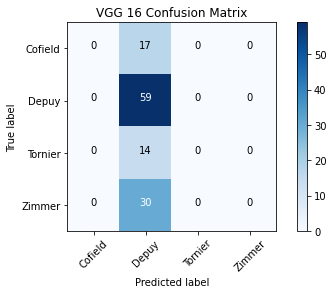

In [ ]:
cm = confusion_matrix(y_true, pred)
import itertools
# note - this confusion matrix code was taken from https://deeplizard.com/learn/video/km7pxKy4UHU
def plot_confusion_matrix(cm, classes, title='VGG 16 Confusion Matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    print("Confusion matrix of test data")
    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
plot_confusion_matrix(cm,['Cofield','Depuy','Tornier','Zimmer'])

### ResNet50:

In [ ]:
# reference: https://zhuanlan.zhihu.com/p/54289848
base_model_resnet = ResNet50(include_top=False, weights="imagenet", input_shape=(256, 256, 3), pooling="avg")

output = base_model_resnet.output
for layer in base_model_resnet.layers:
  layer.trainable = False
y = Dense(4, activation='softmax')(output)
model_resnet_pre = Model(base_model_resnet.input,y)

model_resnet_pre.compile(optimizer = keras.optimizers.Adam(learning_rate=0.00001), loss = 'categorical_crossentropy', metrics=[keras.metrics.CategoricalAccuracy()])

model_resnet_pre.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_7[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [ ]:
history_resnet_pre = model_resnet_pre.fit(x_train, y_train, validation_split=0.15, epochs=25, batch_size=4, verbose=2)

Epoch 1/25
102/102 - 7s - loss: 2.0840 - categorical_accuracy: 0.1210 - val_loss: 1.9153 - val_categorical_accuracy: 0.1111
Epoch 2/25
102/102 - 2s - loss: 1.8710 - categorical_accuracy: 0.1210 - val_loss: 1.7306 - val_categorical_accuracy: 0.1111
Epoch 3/25
102/102 - 2s - loss: 1.6965 - categorical_accuracy: 0.1210 - val_loss: 1.5831 - val_categorical_accuracy: 0.1111
Epoch 4/25
102/102 - 2s - loss: 1.5524 - categorical_accuracy: 0.1210 - val_loss: 1.4678 - val_categorical_accuracy: 0.1111
Epoch 5/25
102/102 - 2s - loss: 1.4430 - categorical_accuracy: 0.1210 - val_loss: 1.3833 - val_categorical_accuracy: 0.1111
Epoch 6/25
102/102 - 2s - loss: 1.3638 - categorical_accuracy: 0.2568 - val_loss: 1.3255 - val_categorical_accuracy: 0.4583
Epoch 7/25
102/102 - 2s - loss: 1.3095 - categorical_accuracy: 0.4988 - val_loss: 1.2894 - val_categorical_accuracy: 0.4583
Epoch 8/25
102/102 - 2s - loss: 1.2736 - categorical_accuracy: 0.4988 - val_loss: 1.2662 - val_categorical_accuracy: 0.4583
Epoch 9/

In [ ]:
model_resnet_pre.evaluate(x_test, y_test)

4/4 [==============================] - 3s 329ms/step - loss: 1.2236 - categorical_accuracy: 0.4917


[1.2236008644104004, 0.49166667461395264]

In [ ]:
pred = model_resnet_pre.predict(x_test)
y_true = inverse_categorical(y_test)
pred = inverse_categorical(pred)

In [ ]:
cm_res = confusion_matrix(y_true, pred)
print(cm_res)

[[ 0 17  0  0]
 [ 0 59  0  0]
 [ 0 14  0  0]
 [ 0 30  0  0]]


Confusion matrix of test data
[[ 0 17  0  0]
 [ 0 59  0  0]
 [ 0 14  0  0]
 [ 0 30  0  0]]


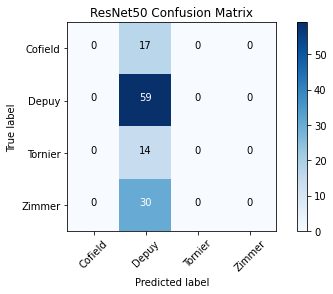

In [ ]:
#cm_res = confusion_matrix(y_true, pred)
import itertools
# note - this confusion matrix code was taken from https://deeplizard.com/learn/video/km7pxKy4UHU
def plot_confusion_matrix(cm, classes, title='ResNet50 Confusion Matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    print("Confusion matrix of test data")
    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
plot_confusion_matrix(cm_res,['Cofield','Depuy','Tornier','Zimmer'])

In [ ]:
output = base_model_resnet.output
for layer in base_model_resnet.layers:
  layer.trainable = False
y = Dense(4, activation='softmax')(output)
model_resnet_pre2 = Model(base_model_resnet.input,y)

model_resnet_pre2.compile(optimizer = keras.optimizers.SGD(lr=0.001, momentum=0.9), loss = 'categorical_crossentropy', metrics=[keras.metrics.CategoricalAccuracy()])

model_resnet_pre2.summary()

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_7[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [ ]:
history_resnet_pre2 = model_resnet_pre2.fit(x_train, y_train, validation_split=0.1, epochs=25, batch_size=4, verbose=2, shuffle=True)

Epoch 1/25
108/108 - 6s - loss: 1.7678 - categorical_accuracy: 0.3660 - val_loss: 1.6952 - val_categorical_accuracy: 0.4583
Epoch 2/25
108/108 - 2s - loss: 1.7886 - categorical_accuracy: 0.3730 - val_loss: 2.3216 - val_categorical_accuracy: 0.4583
Epoch 3/25
108/108 - 2s - loss: 1.9932 - categorical_accuracy: 0.3893 - val_loss: 2.1888 - val_categorical_accuracy: 0.4583
Epoch 4/25
108/108 - 2s - loss: 1.7921 - categorical_accuracy: 0.3800 - val_loss: 1.7287 - val_categorical_accuracy: 0.4583
Epoch 5/25
108/108 - 2s - loss: 1.7991 - categorical_accuracy: 0.3497 - val_loss: 2.6622 - val_categorical_accuracy: 0.4583
Epoch 6/25
108/108 - 2s - loss: 1.9448 - categorical_accuracy: 0.3800 - val_loss: 1.9296 - val_categorical_accuracy: 0.1042
Epoch 7/25
108/108 - 2s - loss: 1.8201 - categorical_accuracy: 0.3497 - val_loss: 1.6181 - val_categorical_accuracy: 0.3125
Epoch 8/25
108/108 - 2s - loss: 1.8105 - categorical_accuracy: 0.3753 - val_loss: 1.9200 - val_categorical_accuracy: 0.4583
Epoch 9/

In [ ]:
model_resnet_pre.evaluate(x_test, y_test)

4/4 [==============================] - 0s 107ms/step - loss: 1.2236 - categorical_accuracy: 0.4917


[1.2236008644104004, 0.49166667461395264]

### VGG from scratch

In [ ]:
base_model_scratch = VGG16(weights=None, include_top=False, input_shape=(256, 256, 3))
x = base_model_scratch.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
#x = Dense(4096, activation='relu')(x)
prediction = Dense(4, activation='softmax')(x)

model_vgg_scratch = Model(base_model_scratch.input,prediction)
# for layer in base_model.layers:
#   layer.trainable = False

model_vgg_scratch.compile(optimizer = keras.optimizers.Adam(0.00003), loss = 'categorical_crossentropy', metrics=[keras.metrics.CategoricalAccuracy()])

model_vgg_scratch.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0     

In [ ]:
history_vgg_scratch = model_vgg_scratch.fit(x_train, y_train, validation_split=0.1, epochs=50, batch_size=32, verbose=2) # tried batch_size of 16, 8, 4

Epoch 1/50
14/14 - 72s - loss: 1.3248 - categorical_accuracy: 0.4662 - val_loss: 1.2333 - val_categorical_accuracy: 0.4583
Epoch 2/50
14/14 - 13s - loss: 1.2574 - categorical_accuracy: 0.4965 - val_loss: 1.2192 - val_categorical_accuracy: 0.4583
Epoch 3/50
14/14 - 13s - loss: 1.2471 - categorical_accuracy: 0.4965 - val_loss: 1.2234 - val_categorical_accuracy: 0.4583
Epoch 4/50
14/14 - 13s - loss: 1.2420 - categorical_accuracy: 0.4965 - val_loss: 1.2501 - val_categorical_accuracy: 0.4583
Epoch 5/50
14/14 - 13s - loss: 1.2658 - categorical_accuracy: 0.4965 - val_loss: 1.2388 - val_categorical_accuracy: 0.4583
Epoch 6/50
14/14 - 13s - loss: 1.2448 - categorical_accuracy: 0.4965 - val_loss: 1.2463 - val_categorical_accuracy: 0.4583
Epoch 7/50
14/14 - 13s - loss: 1.2445 - categorical_accuracy: 0.4988 - val_loss: 1.2271 - val_categorical_accuracy: 0.4583
Epoch 8/50
14/14 - 13s - loss: 1.2238 - categorical_accuracy: 0.4988 - val_loss: 1.2055 - val_categorical_accuracy: 0.4583
Epoch 9/50
14/14

In [ ]:
model_vgg_scratch.evaluate(x_test, y_test)

4/4 [==============================] - 10s 3s/step - loss: 5.4445 - categorical_accuracy: 0.4500


[5.4445366859436035, 0.44999998807907104]

In [ ]:
pred = model_vgg_scratch.predict(x_test)
pred = np.argmax(pred,axis=-1)
true_labels = np.argmax(y_test,axis=-1)
test_results = list(precision_recall_fscore_support(true_labels, pred, average = 'macro')[:-1])
test_results

[0.3787426653805964, 0.3715555713810948, 0.3748103748103748]

### Inception

In [ ]:
path_var = '/content/drive/MyDrive/project_data/' 
images = np.load(path_var + 'images_origin.npy')
labels = np.load(path_var + 'labels.npy')

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(images, labels.astype(int), test_size=0.2, random_state=42, stratify=labels.astype(int))
y_train = keras.utils.to_categorical(y_train, 4)
y_test = keras.utils.to_categorical(y_test, 4)

In [ ]:
def add_new_last_layer(base_model, nb_classes):
  x = base_model.output
  x = keras.layers.GlobalAveragePooling2D()(x)
  x = Dense(256, activation='relu')(x) #new FC layer, random init
  predictions = Dense(nb_classes, activation='softmax')(x) #new softmax layer
  model = Model(base_model.input, predictions)
  return model

In [ ]:
def setup_to_transfer_learn(model, base_model):
  """Freeze all layers and compile the model"""
  for layer in base_model.layers:
    layer.trainable = False
  model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
base_model = InceptionV3(weights='imagenet', include_top=False) 
model = add_new_last_layer(base_model, 4)              
setup_to_transfer_learn(model, base_model)

87916544/87910968 [==============================] - 1s 0us/step


In [ ]:
history_inception = model.fit(x_train, y_train, epochs=25, batch_size=4, validation_split=0.1)

Epoch 1/25
108/108 [==============================] - 14s 76ms/step - loss: 1.8103 - accuracy: 0.4576 - val_loss: 1.0609 - val_accuracy: 0.5417
Epoch 2/25
108/108 [==============================] - 6s 57ms/step - loss: 0.9532 - accuracy: 0.6311 - val_loss: 0.9377 - val_accuracy: 0.5417
Epoch 3/25
108/108 [==============================] - 6s 56ms/step - loss: 0.7117 - accuracy: 0.7123 - val_loss: 1.0878 - val_accuracy: 0.5417
Epoch 4/25
108/108 [==============================] - 6s 57ms/step - loss: 0.5943 - accuracy: 0.7896 - val_loss: 0.9798 - val_accuracy: 0.6042
Epoch 5/25
108/108 [==============================] - 6s 57ms/step - loss: 0.5564 - accuracy: 0.8102 - val_loss: 1.2816 - val_accuracy: 0.5417
Epoch 6/25
108/108 [==============================] - 6s 56ms/step - loss: 0.4781 - accuracy: 0.8049 - val_loss: 1.0453 - val_accuracy: 0.6042
Epoch 7/25
108/108 [==============================] - 6s 57ms/step - loss: 0.3021 - accuracy: 0.9045 - val_loss: 1.6277 - val_accuracy: 0.562

In [ ]:
model.evaluate(x_test, y_test)

4/4 [==============================] - 6s 782ms/step - loss: 1.5983 - accuracy: 0.6583


[1.5982508659362793, 0.6583333611488342]

In [ ]:
pred_in = model.predict(x_test)
pred_in = np.argmax(pred_in,axis=-1)
true_labels = np.argmax(y_test,axis=-1)
test_results = list(precision_recall_fscore_support(true_labels, pred_in, average = 'macro')[:-1])
test_results

[0.6071694006476616, 0.6134394435740398, 0.6065628035445868]

In [ ]:
def setup_to_finetune(model):
  for layer in model.layers[:NB_IV3_LAYERS_TO_FREEZE]:
     layer.trainable = False
  for layer in model.layers[NB_IV3_LAYERS_TO_FREEZE:]:
     layer.trainable = True
  model.compile(keras.optimizers.SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
NB_IV3_LAYERS_TO_FREEZE = 172
#base_model = InceptionV3(weights='imagenet', include_top=False)
model_ince2 = add_new_last_layer(base_model, 4)             
setup_to_finetune(model_ince2)

In [ ]:
history_inception2 = model_ince2.fit(x_train, y_train, epochs=25, batch_size=4, validation_split=0.1)

Epoch 1/25
108/108 [==============================] - 11s 54ms/step - loss: 1.3373 - accuracy: 0.3829 - val_loss: 1.2531 - val_accuracy: 0.4167
Epoch 2/25
108/108 [==============================] - 4s 39ms/step - loss: 1.1602 - accuracy: 0.4693 - val_loss: 1.2477 - val_accuracy: 0.4375
Epoch 3/25
108/108 [==============================] - 4s 39ms/step - loss: 1.0361 - accuracy: 0.5895 - val_loss: 1.2152 - val_accuracy: 0.4375
Epoch 4/25
108/108 [==============================] - 4s 39ms/step - loss: 0.9109 - accuracy: 0.6075 - val_loss: 1.1403 - val_accuracy: 0.4167
Epoch 5/25
108/108 [==============================] - 4s 39ms/step - loss: 0.8299 - accuracy: 0.6838 - val_loss: 1.1221 - val_accuracy: 0.4375
Epoch 6/25
108/108 [==============================] - 4s 39ms/step - loss: 0.7555 - accuracy: 0.7335 - val_loss: 1.0815 - val_accuracy: 0.4167
Epoch 7/25
108/108 [==============================] - 4s 39ms/step - loss: 0.6756 - accuracy: 0.8060 - val_loss: 1.0516 - val_accuracy: 0.520

## NN Model with Data Aug.

### ResNet50

In [ ]:

# Load in the OG Resnet 50 to get the appropriate weights for transfer learning
pretrained = tf.keras.applications.ResNet50(
                  include_top=False,
                  weights="imagenet",
                  )
#ResNet_50_keras.summary()
#pretrained.summary()

94773248/94765736 [==============================] - 1s 0us/step


In [ ]:
def identity_block(x_start, filter1, filter2, filter3,group_name,block_name):
  proper_name = 'Group' + group_name + '_Block' + block_name + '_'
  x = layers.Conv2D(filter1, (1,1),padding='valid', name = proper_name + 'a')(x_start)
  x = layers.BatchNormalization(name = proper_name + 'a_BN')(x)
  x = layers.Activation('relu',name = proper_name + 'a_RELU')(x)
  x = layers.Conv2D(filter2, (3,3),padding='same', name = proper_name + 'b')(x)
  x = layers.BatchNormalization(name = proper_name + 'b_BN')(x)
  x = layers.Activation('relu',name = proper_name + 'b_RELU')(x)
  x = layers.Conv2D(filter3, (1,1),padding='valid', name = proper_name + 'c')(x)
  x = layers.BatchNormalization(name = proper_name + 'c_BN')(x)
  # simply pass starting layer to the end 
  x = layers.add([x, x_start],name = proper_name + 'add')
  x = layers.Activation('relu',name = proper_name + 'c_RELU')(x)
  return x

def projection_block(x_start, filter1, filter2, filter3,group_name,block_name,s = 2):
  proper_name = 'Group' + group_name + '_Block' + block_name + '_'
  x = layers.Conv2D(filter1, (1,1), strides=(s,s),padding='valid', name = proper_name + 'a')(x_start)
  x = layers.BatchNormalization(name = proper_name + 'a_BN')(x)
  x = layers.Activation('relu',name = proper_name + 'a_RELU')(x)
  x = layers.Conv2D(filter2, (3,3),padding='same', name = proper_name + 'b')(x)
  x = layers.BatchNormalization(name = proper_name + 'b_BN')(x)
  x = layers.Activation('relu',name = proper_name + 'b_RELU')(x)
  x = layers.Conv2D(filter3, (1,1),padding='valid', name = proper_name + 'c')(x)
  x = layers.BatchNormalization(name = proper_name + 'c_BN')(x)
  # update the x_start to reflect the change
  x_start = layers.Conv2D(filter3, (1,1), strides = (s,s), padding = 'valid',
                          name = proper_name + 'skip')(x_start)
  x_start = layers.BatchNormalization(name = proper_name + 'skip_BN')(x_start)
  x = layers.add([x_start,x],name = proper_name + 'add')
  x = layers.Activation('relu',name = proper_name + 'c_RELU')(x)
  return x


In [ ]:
def build_Resnet(pretrained, image_net_weights = True):
  
  inputs = keras.Input(shape = (256,256,3))       

  # group 1
  x = layers.ZeroPadding2D(padding = (3,3))(inputs)
  x = layers.Conv2D(64, (7,7),strides=(2,2), 
                padding = 'valid')(x)
  x = layers.BatchNormalization()(x)
  x = layers.Activation('relu')(x)
  x = layers.ZeroPadding2D(padding = (1,1))(x)
  x = layers.MaxPooling2D((3,3), strides=(2,2))(x)

  #group 2
  x = projection_block(x,64,64,256,'2','1',1)
  x = identity_block(x, 64,64,256,'2','2')
  x = identity_block(x, 64,64,256,'2','3')

  #group 3
  x = projection_block(x,128,128,512,'3','1')
  x = identity_block(x,128,128,512,'3','2')
  x = identity_block(x,128,128,512,'3','3')
  x = identity_block(x,128,128,512,'3','4')

  #group 4
  x = projection_block(x,256,256,1024,'4','1')
  x = identity_block(x,256,256,1024,'4','2')
  x = identity_block(x,256,256,1024,'4','3')
  x = identity_block(x,256,256,1024,'4','4')
  x = identity_block(x,256,256,1024,'4','5')
  x = identity_block(x,256,256,1024,'4','6')

  #group 5
  x = projection_block(x,512,512,2048,'5','1')
  x = identity_block(x,512,512,2048,'5','2')
  x = identity_block(x,512,512,2048,'5','3')

  outputs = layers.GlobalAveragePooling2D()(x)
  model = keras.Model(inputs, outputs, name = 'ResNet')
  model.compile(optimizer = 'adam', loss = 'categorical_crossentropy')


  # perform transfer learning
  if image_net_weights:
    model.set_weights(pretrained.get_weights())

  #y= layers.Dropout(0.2)(model.layers[-1].output)
  prediction = layers.Dense(4, activation='softmax')(model.layers[-1].output)
  Resnet_model = keras.Model(inputs, prediction, name = 'Resnet')

  Resnet_model.compile(optimizer = keras.optimizers.SGD(lr=0.001, momentum=0.9),
                       loss = 'categorical_crossentropy',
                metrics=[keras.metrics.CategoricalAccuracy()
                         ])
  return Resnet_model

In [ ]:
# First get the data and split it
path_var = '/content/drive/MyDrive/project_data/'

# labels = np.load(path_var + 'labels.npy')
# images_raw = np.load(path_var + 'images_unstandardized.npy')
labels = np.load(path_var + 'labels_augmented_half.npy')
images_raw = np.load(path_var + 'images_augmented_half.npy')



# Test Train Split with raw images and one hot vectors for labels
x_train, x_test, y_train, y_test = train_test_split(images_raw, labels.astype(int), test_size=0.2, random_state=42, stratify=labels.astype(int))
y_test  = keras.utils.to_categorical(y_test ,4)

In [ ]:
# Stratified 5 fold cross validation to train the model
kf = StratifiedKFold(n_splits = 5)
# stores the loss and use it to update the model
validation_errors = []
best_loss = 0

# split training data into true train and validation 
for train_index,valid_index in kf.split(x_train,y_train):
  x_train_split, x_valid_split = x_train[train_index], x_train[valid_index]
  y_train_split, y_valid_split = y_train[train_index], y_train[valid_index]
  #convert to one hot encoding for classification
  y_train_split= keras.utils.to_categorical(y_train_split, 4)
  y_valid_split = keras.utils.to_categorical(y_valid_split,4)
  # build the pre-trained model
  model = build_Resnet(pretrained)
  # low batch size for preventing RAM crash
  model.fit(x_train_split,y_train_split, batch_size = 4, epochs=20)
  # perform testing and save error
  results = model.evaluate(x_valid_split, y_valid_split, batch_size=4)
  pred = model.predict(x_valid_split)
  pred = np.argmax(pred,axis=-1)
  true_labels_split = np.argmax(y_valid_split,axis=-1)
  # generate a list of scores
  results = results[0:2] + list(precision_recall_fscore_support(true_labels_split, pred, average = 'macro')[:3])
  results = [round(x,4) for x in results]
  validation_errors.append(results[0]) # for updating the model, we just need the loss
  # need to save the best model
  if len(validation_errors) == 1:
    best_loss = validation_errors[0]
    model.save('/content/drive/MyDrive/project_data/Resnet')
  elif validation_errors[-1] < best_loss: # if find a better model
    model.save('/content/drive/MyDrive/project_data/Resnet')
    best_loss = validation_errors[-1]
print(best_loss)

# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
model = tf.keras.models.load_model('/content/drive/MyDrive/project_data/Resnet')
model.compile(optimizer = keras.optimizers.SGD(lr=0.001, momentum=0.9),
                       loss = 'categorical_crossentropy',
                metrics=[keras.metrics.CategoricalAccuracy()
                         ])
test_results = model.evaluate(x_test, y_test, batch_size=4)
pred = model.predict(x_test)
pred = np.argmax(pred,axis=-1)
true_labels = np.argmax(y_test,axis=-1)
test_results = test_results[0:2] + list(precision_recall_fscore_support(true_labels, pred, average = 'macro')[:3])
test_results = [round(x,4) for x in test_results]
name = ["test loss", "test accuracy", "test_precision", "test_recall", "test_f1score"]
test_iter = zip(name, test_results)
show_test = dict(test_iter)
print("test results:", show_test)

Evaluate on test data
112/112 [==============================] - 3s 23ms/step - loss: 0.6951 - categorical_accuracy: 0.8514
test results: {'test loss': 0.6846, 'test accuracy': 0.8434, 'test_precision': 0.8421, 'test_recall': 0.8289, 'test_f1score': 0.8345}


### 10 folds CV of ResNet

In [ ]:

# Stratified 5 fold cross validation to train the model
kf = StratifiedKFold(n_splits = 10)
validation_errors = []
best_loss = 0

# With only the train data, split into validation/train
for train_index,valid_index in kf.split(x_train,y_train):
  x_train_split, x_valid_split = x_train[train_index], x_train[valid_index]
  y_train_split, y_valid_split = y_train[train_index], y_train[valid_index]
  #convert to one hot encoding
  y_train_split= keras.utils.to_categorical(y_train_split, 4)
  y_valid_split = keras.utils.to_categorical(y_valid_split,4)
  # build the model
  model = build_Resnet(pretrained)
  # low batch size for preventing RAM crash
  model.fit(x_train_split,y_train_split, batch_size = 4, epochs=25)
  # perform testing and save error
  results = model.evaluate(x_valid_split, y_valid_split, batch_size=4)
  pred = model.predict(x_valid_split)
  pred = np.argmax(pred,axis=-1)
  true_labels_split = np.argmax(y_valid_split,axis=-1)
  # get a list of scores
  results = results[0:2] + list(precision_recall_fscore_support(true_labels_split, pred, average = 'macro')[:-1])
  results = [round(x,4) for x in results]
  validation_errors.append(results[0]) # only care about the loss
  # need to save the best model to then use in test
  if len(validation_errors) == 1:
    best_loss = validation_errors[0]
    model.save('/content/drive/MyDrive/data/Resnet')
  elif validation_errors[-1] < best_loss: # new append loss is the lowest one
    model.save('/content/drive/MyDrive/data/Resnet')
    best_loss = validation_errors[-1] # update
print(best_loss)

# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
model = tf.keras.models.load_model('/content/drive/MyDrive/data/Resnet')
model.compile(optimizer = keras.optimizers.SGD(lr=0.001, momentum=0.9),
                       loss = 'categorical_crossentropy',
                metrics=[keras.metrics.CategoricalAccuracy()
                         ])
test_results = model.evaluate(x_test, y_test, batch_size=4)
pred = model.predict(x_test)
pred = np.argmax(pred,axis=-1)
true_labels = np.argmax(y_test,axis=-1)
test_results = test_results[0:2] + list(precision_recall_fscore_support(true_labels, pred, average = 'macro')[:-1])
test_results = [round(x,4) for x in test_results]
name = ["test loss", "test accuracy", "test_precision", "test_recall", "test_f1score"]
test_iter = zip(name, test_results)
show_test = dict(test_iter)
print("test results:", show_test)

Epoch 1/25
724/724 [==============================] - 38s 45ms/step - loss: 1.3398 - categorical_accuracy: 0.4692
Epoch 2/25
724/724 [==============================] - 33s 45ms/step - loss: 0.8182 - categorical_accuracy: 0.6640
Epoch 3/25
724/724 [==============================] - 33s 46ms/step - loss: 0.5252 - categorical_accuracy: 0.7966
Epoch 4/25
724/724 [==============================] - 33s 45ms/step - loss: 0.3805 - categorical_accuracy: 0.8601
Epoch 5/25
724/724 [==============================] - 33s 45ms/step - loss: 0.2408 - categorical_accuracy: 0.9139
Epoch 6/25
724/724 [==============================] - 33s 45ms/step - loss: 0.1771 - categorical_accuracy: 0.9423
Epoch 7/25
724/724 [==============================] - 33s 46ms/step - loss: 0.1517 - categorical_accuracy: 0.9442
Epoch 8/25
724/724 [==============================] - 33s 45ms/step - loss: 0.1145 - categorical_accuracy: 0.9599
Epoch 9/25
724/724 [==============================] - 33s 46ms/step - loss: 0.0622 - cat

In [ ]:
path_var_new = '/content/drive/MyDrive/project_data/'
images_raw = np.load(path_var_new + 'images_origin.npy')
labels = np.load(path_var_new + 'labels.npy')
print(images_raw.shape, labels.shape)

(597, 256, 256, 3) (597,)


In [ ]:
print("Evaluate on test data")
model = tf.keras.models.load_model('/content/drive/MyDrive/project_data/resnet')
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy',
                metrics=[keras.metrics.CategoricalAccuracy()])
test_results = model.evaluate(images_raw,keras.utils.to_categorical(labels ,4), batch_size=4)
pred = model.predict(images_raw)
pred = np.argmax(pred,axis=-1)
true_labels = np.argmax(keras.utils.to_categorical(labels ,4),axis=-1)
test_results = test_results[0:2] + list(precision_recall_fscore_support(true_labels, pred, average = 'macro')[:-1])
test_results = [round(x,4) for x in test_results]
name = ["test loss", "test accuracy", "test_precision", "test_recall", "test_f1score"]
test_iter = zip(name, test_results)
show_test = dict(test_iter)
print("test results:", show_test)

Evaluate on test data
150/150 [==============================] - 4s 18ms/step - loss: 0.2755 - categorical_accuracy: 0.9336
test results: {'test loss': 0.2882, 'test accuracy': 0.9414, 'test_precision': 0.9484, 'test_recall': 0.9161, 'test_f1score': 0.9302}


Confusion matrix, without normalization
[[ 73   2   0   8]
 [  0 286   1   7]
 [  0   5  61   5]
 [  2   5   0 142]]


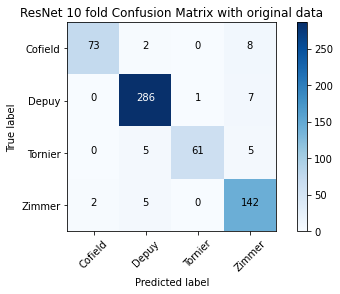

In [ ]:
cm = confusion_matrix(true_labels, pred)
import itertools
# reference: https://deeplizard.com/learn/video/km7pxKy4UHU
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='ResNet 10 fold Confusion Matrix with original data',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
plot_confusion_matrix(cm,['Cofield','Depuy','Tornier','Zimmer'])

In [ ]:
path_var_new = '/content/drive/MyDrive/project_data/'
images_raw = np.load(path_var_new + 'test_for_aug.npy')
labels = np.load(path_var_new + 'test_label_for_aug.npy')
print(images_raw.shape, labels.shape)

(150, 256, 256, 3) (150,)


In [ ]:
print("Evaluate on test for augmentation data")
model = tf.keras.models.load_model('/content/drive/MyDrive/project_data/resnet')
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy',
                metrics=[keras.metrics.CategoricalAccuracy()])
test_results = model.evaluate(images_raw,keras.utils.to_categorical(labels ,4), batch_size=4)
pred = model.predict(images_raw)
pred = np.argmax(pred,axis=-1)
true_labels = np.argmax(keras.utils.to_categorical(labels ,4),axis=-1)
test_results = test_results[0:2] + list(precision_recall_fscore_support(true_labels, pred, average = 'macro')[:-1])
test_results = [round(x,4) for x in test_results]
name = ["test loss", "test accuracy", "test_precision", "test_recall", "test_f1score"]
test_iter = zip(name, test_results)
show_test = dict(test_iter)
print("test results:", show_test)

Evaluate on test for augmentation data
38/38 [==============================] - 32s 22ms/step - loss: 0.9891 - categorical_accuracy: 0.7713
test results: {'test loss': 1.1345, 'test accuracy': 0.7733, 'test_precision': 0.8137, 'test_recall': 0.7201, 'test_f1score': 0.7461}


Confusion matrix, without normalization
[[18  2  0  8]
 [ 0 57  1  7]
 [ 0  4 11  5]
 [ 2  5  0 30]]


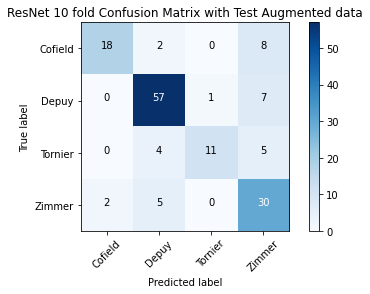

In [ ]:
cm = confusion_matrix(true_labels, pred)
import itertools
# reference: https://deeplizard.com/learn/video/km7pxKy4UHU
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='ResNet 10 fold Confusion Matrix with Test Augmented data',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
plot_confusion_matrix(cm,['Cofield','Depuy','Tornier','Zimmer'])

### Inception

In [ ]:
path_var = '/content/drive/MyDrive/project_data/'

#labels = np.load(path_var + 'labels.npy')
#images_raw = np.load(path_var + 'images_unstandardized.npy')
labels = np.load(path_var + 'labels_augmented.npy')
images_raw = np.load(path_var + 'images_augmented.npy')

# train test split

x_train, x_test, y_train, y_test = train_test_split(images_raw, labels.astype(int), test_size=0.2, random_state=42, stratify=labels.astype(int))
y_train = keras.utils.to_categorical(y_train, 4)
y_test = keras.utils.to_categorical(y_test, 4)

In [ ]:
def add_new_last_layer(base_model, nb_classes):
  x = base_model.output
  x = keras.layers.GlobalAveragePooling2D()(x)
  x = keras.layers.Dense(256, activation='relu')(x) #new FC layer, random init
  predictions = keras.layers.Dense(nb_classes, activation='softmax')(x) #new softmax layer
  model = keras.Model(base_model.input, predictions)
  return model

In [ ]:
def setup_to_transfer_learn(model, base_model):
  """Freeze all layers and compile the model"""
  for layer in base_model.layers:
    layer.trainable = False
  model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
base_model = InceptionV3(weights='imagenet', include_top=False)
model_aug = add_new_last_layer(base_model, 4)             
setup_to_transfer_learn(model_aug, base_model)

In [ ]:
history_inception_aug = model_aug.fit(x_train, y_train, epochs=25, batch_size=4, validation_split=0.1)

Epoch 1/25
403/403 [==============================] - 38s 29ms/step - loss: 1.2232 - accuracy: 0.5005 - val_loss: 0.9029 - val_accuracy: 0.5978
Epoch 2/25
403/403 [==============================] - 9s 23ms/step - loss: 0.7880 - accuracy: 0.6842 - val_loss: 0.9786 - val_accuracy: 0.5866
Epoch 3/25
403/403 [==============================] - 9s 23ms/step - loss: 0.6509 - accuracy: 0.7479 - val_loss: 0.8283 - val_accuracy: 0.6592
Epoch 4/25
403/403 [==============================] - 9s 23ms/step - loss: 0.5575 - accuracy: 0.7740 - val_loss: 0.7603 - val_accuracy: 0.6872
Epoch 5/25
403/403 [==============================] - 9s 23ms/step - loss: 0.5184 - accuracy: 0.8005 - val_loss: 0.8156 - val_accuracy: 0.6927
Epoch 6/25
403/403 [==============================] - 9s 23ms/step - loss: 0.4558 - accuracy: 0.8345 - val_loss: 0.8102 - val_accuracy: 0.6592
Epoch 7/25
403/403 [==============================] - 9s 23ms/step - loss: 0.4045 - accuracy: 0.8536 - val_loss: 0.8723 - val_accuracy: 0.653

In [ ]:
model_aug.evaluate(x_test, y_test)

14/14 [==============================] - 4s 185ms/step - loss: 0.7203 - accuracy: 0.7584


[0.7202593088150024, 0.7583892345428467]

In [ ]:
test_img = np.load(path_var + 'test_for_aug.npy')
test_label = np.load(path_var + 'test_label_for_aug.npy')
print(test_img.shape, test_label.shape)

(150, 256, 256, 3) (150,)


In [ ]:
pred = model_aug.predict(test_img)
pred = np.argmax(pred, axis = -1)

Confusion matrix, without normalization
[[13  7  0  8]
 [ 2 56  0  7]
 [ 1  6 10  3]
 [ 6 15  5 11]]


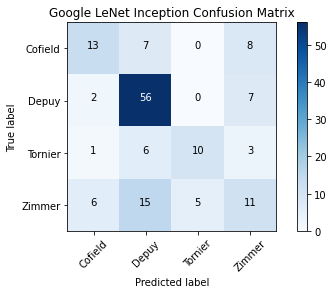

In [ ]:
cm = confusion_matrix(test_label, pred)
import itertools
# Reference: https://deeplizard.com/learn/video/km7pxKy4UHU
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Google LeNet Inception Confusion Matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
plot_confusion_matrix(cm,['Cofield','Depuy','Tornier','Zimmer'])

### 5 fold Inception

In [ ]:
path_var = '/content/drive/MyDrive/project_data/'

#labels = np.load(path_var + 'labels.npy')
#images_raw = np.load(path_var + 'images_unstandardized.npy')
labels = np.load(path_var + 'labels_augmented_half.npy')
images_raw = np.load(path_var + 'images_augmented_half.npy')


# train test split
x_train, x_test, y_train, y_test = train_test_split(images_raw, 
                                                      labels.astype(int), 
                                                     test_size=0.2,random_state=42,
                                                     stratify=labels.astype(int))
y_test  = keras.utils.to_categorical(y_test ,4)
# x_train, x_test, y_train, y_test = train_test_split(images_raw, labels.astype(int), test_size=0.2, random_state=42, stratify=labels.astype(int))
# y_train = keras.utils.to_categorical(y_train, 4)
# y_test = keras.utils.to_categorical(y_test, 4)

In [ ]:
base_model_incep = InceptionV3(weights='imagenet', include_top=False)
model_incep = add_new_last_layer(base_model_incep, 4)             
setup_to_transfer_learn(model_incep, base_model_incep)

In [ ]:
kf = StratifiedKFold(n_splits = 5)
validation_errors = []
best_loss = 0

# With only the train data, split into validation/train
for train_index,valid_index in kf.split(x_train,y_train):
  x_train_split, x_valid_split = x_train[train_index], x_train[valid_index]
  y_train_split, y_valid_split = y_train[train_index], y_train[valid_index]
  #convert to one hot encoding
  y_train_split= keras.utils.to_categorical(y_train_split, 4)
  y_valid_split = keras.utils.to_categorical(y_valid_split,4)
  # fit the model
  model_incep.fit(x_train_split,y_train_split, batch_size = 4, epochs=25)
  # perform testing and save results to validation_errors
  results = model_incep.evaluate(x_valid_split, y_valid_split, batch_size=4)
  pred = model_incep.predict(x_valid_split)
  pred = np.argmax(pred,axis=-1)
  true_labels_split = np.argmax(y_valid_split,axis=-1)
  # 
  results = results[0:2] + list(precision_recall_fscore_support(true_labels_split, pred, average = 'macro')[:3])
  results = [round(x,4) for x in results]
  validation_errors.append(results[0])
  # need to save the best model to then use in test
  if len(validation_errors) == 1:
    best_loss = validation_errors[0]
    model_incep.save('/content/drive/MyDrive/project_data/Inception')
  elif best_loss > validation_errors[-1]:
    model_incep.save('/content/drive/MyDrive/project_data/Inception')
    best_loss = validation_errors[-1]
print(best_loss)

# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
model = tf.keras.models.load_model('/content/drive/MyDrive/project_data/Inception')
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
test_results = model.evaluate(x_test, y_test, batch_size=4)
pred = model.predict(x_test)
pred = np.argmax(pred,axis=-1)
true_labels = np.argmax(y_test,axis=-1)
test_results = test_results[0:2] + list(precision_recall_fscore_support(true_labels, pred, average = 'macro')[:3])
test_results = [round(x,4) for x in test_results]
name = ["test loss", "test accuracy", "test_precision", "test_recall", "test_f1score"]
test_iter = zip(name, test_results)
show_test = dict(test_iter)
print("test results:", show_test)

Epoch 1/25
358/358 [==============================] - 44s 22ms/step - loss: 1.3554 - accuracy: 0.4836
Epoch 2/25
358/358 [==============================] - 7s 20ms/step - loss: 0.8407 - accuracy: 0.6650
Epoch 3/25
358/358 [==============================] - 7s 20ms/step - loss: 0.7196 - accuracy: 0.7105
Epoch 4/25
358/358 [==============================] - 7s 21ms/step - loss: 0.5883 - accuracy: 0.7597
Epoch 5/25
358/358 [==============================] - 7s 21ms/step - loss: 0.4692 - accuracy: 0.8314
Epoch 6/25
358/358 [==============================] - 7s 21ms/step - loss: 0.4131 - accuracy: 0.8365
Epoch 7/25
358/358 [==============================] - 7s 21ms/step - loss: 0.3349 - accuracy: 0.8755
Epoch 8/25
358/358 [==============================] - 7s 21ms/step - loss: 0.2899 - accuracy: 0.8977
Epoch 9/25
358/358 [==============================] - 7s 21ms/step - loss: 0.2203 - accuracy: 0.9113
Epoch 10/25
358/358 [==============================] - 7s 21ms/step - loss: 0.1855 - accur

In [ ]:
path_var_new = '/content/drive/MyDrive/project_data/'
images_raw = np.load(path_var_new + 'test_for_aug.npy')
labels = np.load(path_var_new + 'test_label_for_aug.npy')
print(images_raw.shape, labels.shape)

(150, 256, 256, 3) (150,)


In [ ]:
print("Evaluate on test for augmentation data")
model = tf.keras.models.load_model('/content/drive/MyDrive/project_data/Inception')
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy',
                metrics=[keras.metrics.CategoricalAccuracy()])
test_results = model.evaluate(images_raw,keras.utils.to_categorical(labels ,4), batch_size=4)
pred = model.predict(images_raw)
pred = np.argmax(pred,axis=-1)
test_results = test_results[0:2] + list(precision_recall_fscore_support(true_labels, pred, average = 'macro')[:-1])
test_results = [round(x,4) for x in test_results]
name = ["test loss", "test accuracy", "test_precision", "test_recall", "test_f1score"]
test_iter = zip(name, test_results)
show_test = dict(test_iter)
print("test results:", show_test)

Evaluate on test for augmentation data
38/38 [==============================] - 3s 27ms/step - loss: 4.3434 - categorical_accuracy: 0.5238
test results: {'test loss': 4.0056, 'test accuracy': 0.5533, 'test_precision': 0.514, 'test_recall': 0.4801, 'test_f1score': 0.4883}


### Vision Transformer from sratch

Reference https://keras.io/examples/vision/image_classification_with_vision_transformer/

In [ ]:
!pip install tensorflow_addons
import tensorflow_addons as tfa
!pip install --quiet vit-keras
from vit_keras import vit

     |████████████████████████████████| 706kB 6.5MB/s 


In [ ]:
path_var = '/content/drive/MyDrive/project_data/'
labels = np.load(path_var + 'labels_augmented_half.npy')
images_raw = np.load(path_var + 'images_augmented_half.npy')

In [ ]:
# labels_cat = keras.utils.to_categorical(labels)
# print(labels_cat.shape)

(597, 4)


In [ ]:
x_train, x_test, y_train, y_test = train_test_split(images_raw, labels.astype(int), test_size=0.2, random_state=42, stratify=labels.astype(int))

In [ ]:
def mlp_layer(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = keras.layers.Dense(units, activation = tf.nn.gelu)(x)
        x = keras.layers.Dropout(dropout_rate)(x)
    return x

class Patches(keras.layers.Layer): # split image to small blocks
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images = images,
            sizes = [1, self.patch_size, self.patch_size, 1],
            strides = [1, self.patch_size, self.patch_size, 1],
            rates = [1, 1, 1, 1],
            padding = 'VALID',
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

Visualize the effect of different patch size

(-0.5, 255.5, 255.5, -0.5)

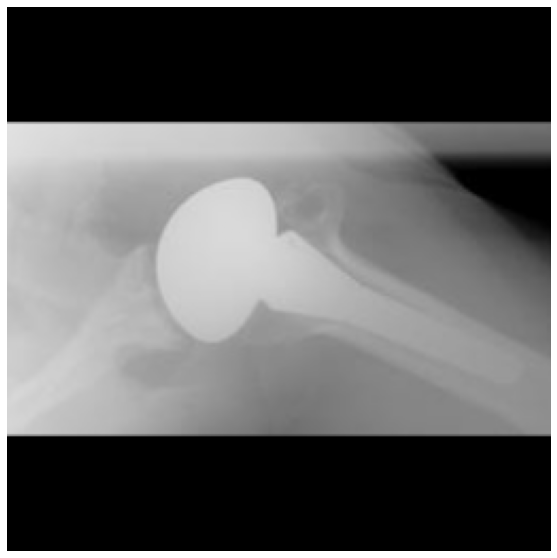

In [ ]:
plt.figure(figsize=(10, 10))
plt.imshow(images_raw[0])
plt.axis('off')

In [ ]:
test_img = images_raw[0]
new_img = tf.expand_dims(test_img, axis=0)
print(np.min(new_img), np.max(new_img))

0.0 0.887837


In [ ]:
def create_patch(patch_size, img):
  patches = Patches(patch_size)(img)
  print(f'Image size: {256} X {256}')
  print(f'Patch size: {patch_size} X {patch_size}')
  print(f'Patches per image: {patches.shape[1]}')
  print(f'Elements per patch: {patches.shape[-1]}')
  return patches
patches_att = create_patch(10, new_img)

Image size: 256 X 256
Patch size: 10 X 10
Patches per image: 625
Elements per patch: 300


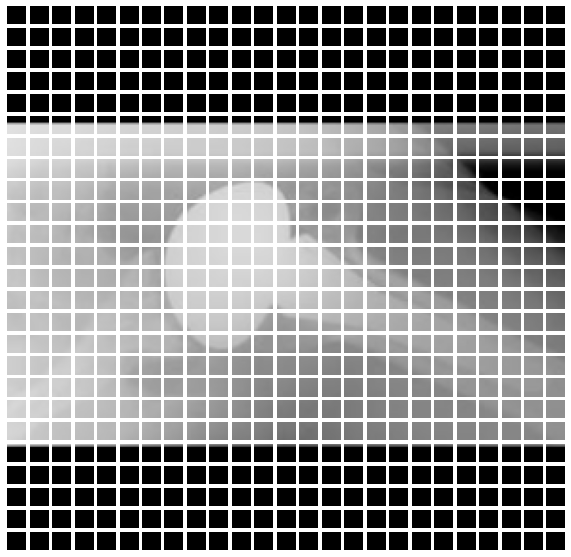

In [ ]:
def plot_attention(patches, patch_size):
  n = int(np.sqrt(patches.shape[1]))
  plt.figure(figsize=(10, 10))

  for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype('float32'))
    plt.axis('off')

plot_attention(patches_att, 10)

(-0.5, 255.5, 255.5, -0.5)

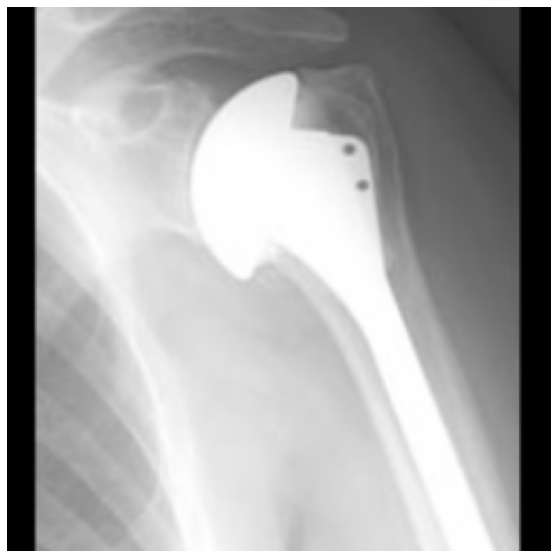

In [ ]:
plt.figure(figsize=(10, 10))
plt.imshow(images_raw[32])
plt.axis('off')

In [ ]:
test_img = images_raw[32]
new_img = tf.expand_dims(test_img, axis=0)
print(np.min(new_img), np.max(new_img))

patches_att = create_patch(20, new_img)

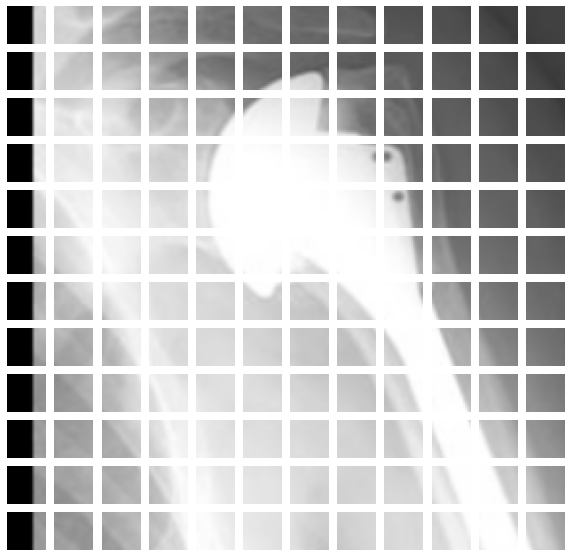

In [ ]:
plot_attention(patches_att, 20)

In [ ]:
# Vision Transformer hyper parameters

learning_rate = 0.001
weight_decay = 0.0001
num_epochs = 25 # default

patch_size = 20  # Size of the patches to be extract from the input images
num_patches = (256 // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier

In [ ]:
class PatchEncoder(keras.layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = keras.layers.Dense(units = projection_dim)
        self.position_embedding = keras.layers.Embedding(
            input_dim = num_patches, output_dim = projection_dim
        )

    def call(self, patch):
        positions = tf.range(start = 0, limit = self.num_patches, delta = 1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

def vision_transformer():
    inputs = keras.layers.Input(shape = (256, 256, 3))
    
    # Create patches.
    patches = Patches(patch_size)(inputs)
    
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        
        # Layer normalization 1.
        x = keras.layers.LayerNormalization(epsilon = 1e-5)(encoded_patches)
        
        # Create a multi-head attention layer.
        attention_output = keras.layers.MultiHeadAttention(
            num_heads = num_heads, key_dim = projection_dim, dropout = 0.1
        )(x, x)
        
        # Skip connection 1.
        y = keras.layers.Add()([attention_output, encoded_patches])
        
        # Layer normalization 2.
        z = keras.layers.LayerNormalization(epsilon = 1e-5)(y)
        
        # MLP.
        z = mlp_layer(z, hidden_units = transformer_units, dropout_rate = 0.1)
        
        # Skip connection 2.
        encoded_patches = keras.layers.Add()([z, y])

    # Create tensor.
    representation = keras.layers.LayerNormalization(epsilon = 1e-6)(encoded_patches)
    representation = keras.layers.Flatten()(representation)
    representation = keras.layers.Dropout(0.5)(representation)
    
    # Add MLP layer
    features = mlp_layer(representation, hidden_units = mlp_head_units, dropout_rate = 0.5)
    
    # Classify outputs.
    logits = keras.layers.Dense(4)(features)
    
    # Create the model.
    model = tf.keras.Model(inputs = inputs, outputs = logits)
    
    return model

In [ ]:
decay_steps = 10
initial_learning_rate = learning_rate
lr_decayed_fn = tf.keras.experimental.CosineDecay(initial_learning_rate, decay_steps)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lr_decayed_fn)

optimizer = tfa.optimizers.AdamW(learning_rate = learning_rate, weight_decay=weight_decay)

model = vision_transformer()
    
model.compile(optimizer = optimizer, 
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              metrics = [keras.metrics.SparseCategoricalAccuracy(name="accuracy")])

# earlystopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy',
#                                                  min_delta = 1e-4,
#                                                  patience = 5,
#                                                  mode = 'max',
#                                                  restore_best_weights = True,
#                                                  verbose = 1)

callbacks = [lr_scheduler]

# labels = keras.utils.to_categorical(labels, 4)

model.fit(x_train, y_train, epochs = 100, batch_size = 4, validation_split=0.2)

Epoch 1/100
358/358 [==============================] - 37s 71ms/step - loss: 8.4174 - accuracy: 0.3414 - val_loss: 1.1999 - val_accuracy: 0.5279
Epoch 2/100
358/358 [==============================] - 24s 67ms/step - loss: 1.4384 - accuracy: 0.4195 - val_loss: 1.1713 - val_accuracy: 0.5335
Epoch 3/100
358/358 [==============================] - 24s 67ms/step - loss: 1.3804 - accuracy: 0.4330 - val_loss: 1.1759 - val_accuracy: 0.5363
Epoch 4/100
358/358 [==============================] - 24s 67ms/step - loss: 1.2617 - accuracy: 0.4975 - val_loss: 1.2012 - val_accuracy: 0.5251
Epoch 5/100
358/358 [==============================] - 24s 67ms/step - loss: 1.2665 - accuracy: 0.4560 - val_loss: 1.1675 - val_accuracy: 0.5335
Epoch 6/100
358/358 [==============================] - 24s 67ms/step - loss: 1.2629 - accuracy: 0.4727 - val_loss: 1.1920 - val_accuracy: 0.5335
Epoch 7/100
358/358 [==============================] - 24s 67ms/step - loss: 1.2472 - accuracy: 0.4832 - val_loss: 1.1739 - val_ac

In [ ]:
model.evaluate(x_test, y_test)

14/14 [==============================] - 1s 64ms/step - loss: 1.2275 - accuracy: 0.4966


[1.2274881601333618, 0.4966442883014679]

In [ ]:
path_var_new = '/content/drive/MyDrive/project_data/'
images_raw = np.load(path_var_new + 'test_for_aug.npy')
labels = np.load(path_var_new + 'test_label_for_aug.npy')

In [ ]:
vit_pred = model.predict(images_raw)
#list(precision_recall_fscore_support(int(labels), np.argmax(vit_pred,axis=-1), average = 'macro')[:-1])
vit_pred = np.argmax(vit_pred, axis=-1)

In [ ]:
list(precision_recall_fscore_support(labels, vit_pred, average = 'macro')[:-1])

[0.33586711711711714, 0.3000965250965251, 0.2812690743018612]

In [ ]:
accuracy_score(labels, vit_pred)

0.43333333333333335

### Vision Transformer Fine Tune:

Reference：https://github.com/faustomorales/vit-keras/blob/1805a98633c5094a7a45f8535f91364b143f4f26/vit_keras/vit.py#L123

In [ ]:
vit_model = vit.vit_b32( # fine tune the top layer
        image_size = 256,
        activation = 'softmax',
        pretrained = True,
        include_top = True,
        pretrained_top = False,
        classes = 4)

vit_model.summary()

/usr/local/lib/python3.7/dist-packages/vit_keras/utils.py:79: UserWarning: Resizing position embeddings from 12 to 8
  UserWarning,


Model: "vit-b32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 256, 256, 3)]     0         
_________________________________________________________________
embedding (Conv2D)           (None, 8, 8, 768)         2360064   
_________________________________________________________________
reshape_1 (Reshape)          (None, 64, 768)           0         
_________________________________________________________________
class_token (ClassToken)     (None, 65, 768)           768       
_________________________________________________________________
Transformer/posembed_input ( (None, 65, 768)           49920     
_________________________________________________________________
Transformer/encoderblock_0 ( ((None, 65, 768), (None,  7087872   
_________________________________________________________________
Transformer/encoderblock_1 ( ((None, 65, 768), (None,  7087

In [ ]:
# model_vitFT = tf.keras.Sequential([
#         vit_model,
#         tf.keras.layers.Flatten(),
#         tf.keras.layers.BatchNormalization(),
#         tf.keras.layers.Dense(128, activation = tfa.activations.gelu),
#         tf.keras.layers.Dense(4, 'softmax')
#         ],
#         name = 'vision_transformer')

# model_vitFT.summary()

Model: "vision_transformer"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vit-b32 (Functional)         (None, 768)               87466752  
_________________________________________________________________
flatten_4 (Flatten)          (None, 768)               0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 768)               3072      
_________________________________________________________________
dense_8 (Dense)              (None, 128)               98432     
_________________________________________________________________
batch_normalization_9 (Batch (None, 128)               512       
_________________________________________________________________
dense_9 (Dense)              (None, 4)                 516       
Total params: 87,569,284
Trainable params: 87,567,492
Non-trainable params: 1,792
________________________________

/usr/local/lib/python3.7/dist-packages/tensorflow_addons/activations/gelu.py:81: UserWarning: Default value of `approximate` is changed from `True` to `False`
  "Default value of `approximate` is changed from `True` to `False`"


In [ ]:
initial_learning_rate = 3e-5

lr_decayed_fn = tf.keras.experimental.CosineDecay(initial_learning_rate, 5)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lr_decayed_fn)

optimizer = tf.keras.optimizers.Adam(learning_rate = 3e-5)

# model_vitFT.compile(optimizer = optimizer, 
#               loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing = 0.1), 
#               metrics = ['accuracy'])
vit_model.compile(optimizer = optimizer, 
              loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing = 0.1), 
              metrics = ['accuracy'])

#model_vitFT.fit(images_raw, labels_cat, batch_size = 4, validation_split = 0.1, epochs=5, callbacks=[lr_scheduler])
vit_model.fit(x_train, y_train_cat, batch_size = 8, validation_split = 0.1, epochs=25, callbacks=[lr_scheduler])

Epoch 1/25
202/202 [==============================] - 73s 151ms/step - loss: 1.2548 - accuracy: 0.4826 - val_loss: 0.9889 - val_accuracy: 0.6536
Epoch 2/25
202/202 [==============================] - 28s 139ms/step - loss: 0.8890 - accuracy: 0.7087 - val_loss: 0.7671 - val_accuracy: 0.7654
Epoch 3/25
202/202 [==============================] - 28s 141ms/step - loss: 0.6908 - accuracy: 0.8217 - val_loss: 0.6613 - val_accuracy: 0.8827
Epoch 4/25
202/202 [==============================] - 29s 142ms/step - loss: 0.5105 - accuracy: 0.9483 - val_loss: 0.6389 - val_accuracy: 0.8771
Epoch 5/25
202/202 [==============================] - 29s 143ms/step - loss: 0.4672 - accuracy: 0.9614 - val_loss: 0.6219 - val_accuracy: 0.8715
Epoch 6/25
202/202 [==============================] - 29s 144ms/step - loss: 0.4466 - accuracy: 0.9758 - val_loss: 0.6219 - val_accuracy: 0.8715
Epoch 7/25
202/202 [==============================] - 29s 145ms/step - loss: 0.4535 - accuracy: 0.9752 - val_loss: 0.6219 - val_ac

In [ ]:
vit_model.evaluate(x_test, y_test_cat)

14/14 [==============================] - 2s 152ms/step - loss: 0.6538 - accuracy: 0.8568


[0.653831422328949, 0.8568232655525208]

In [ ]:
test_images = np.load(path_var + 'test_for_aug.npy')
test_label = np.load(path_var + 'test_label_for_aug.npy')

In [ ]:
vit_pred = vit_model.predict(test_images)
vit_pred = np.argmax(vit_pred,axis=-1)
precision_recall_fscore_support(test_label, vit_pred)

(array([0.77777778, 0.62921348, 0.66666667, 0.61290323]),
 array([0.5       , 0.86153846, 0.4       , 0.51351351]),
 array([0.60869565, 0.72727273, 0.5       , 0.55882353]),
 array([28, 65, 20, 37]))

In [ ]:
vit_model2 = vit.vit_b32(
        image_size = 256,
        activation = 'softmax',
        pretrained = True,
        include_top = True,
        pretrained_top = False,
        classes = 4,
        weights="imagenet21k+imagenet2012")

vit_model2.summary()

/usr/local/lib/python3.7/dist-packages/vit_keras/utils.py:79: UserWarning: Resizing position embeddings from 12 to 8
  UserWarning,


Model: "vit-b32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
embedding (Conv2D)           (None, 8, 8, 768)         2360064   
_________________________________________________________________
reshape_5 (Reshape)          (None, 64, 768)           0         
_________________________________________________________________
class_token (ClassToken)     (None, 65, 768)           768       
_________________________________________________________________
Transformer/posembed_input ( (None, 65, 768)           49920     
_________________________________________________________________
Transformer/encoderblock_0 ( ((None, 65, 768), (None,  7087872   
_________________________________________________________________
Transformer/encoderblock_1 ( ((None, 65, 768), (None,  7087

In [ ]:
initial_learning_rate = 3e-5

lr_decayed_fn = tf.keras.experimental.CosineDecay(initial_learning_rate, 10)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lr_decayed_fn)

optimizer = tf.keras.optimizers.Adam(learning_rate = 3e-5)

# model_vitFT.compile(optimizer = optimizer, 
#               loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing = 0.1), 
#               metrics = ['accuracy'])
vit_model2.compile(optimizer = optimizer, 
              loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing = 0.2), 
              metrics = ['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy', min_delta = 1e-4, patience = 8, mode = 'max', restore_best_weights = True, verbose = 1)

#model_vitFT.fit(images_raw, labels_cat, batch_size = 4, validation_split = 0.1, epochs=5, callbacks=[lr_scheduler])
vit_model2.fit(x_train, y_train_cat, batch_size = 8, validation_split = 0.1, epochs=50, callbacks=[early_stopping])

Epoch 1/50
202/202 [==============================] - 46s 162ms/step - loss: 1.3100 - accuracy: 0.4914 - val_loss: 1.0631 - val_accuracy: 0.6313
Epoch 2/50
202/202 [==============================] - 30s 149ms/step - loss: 1.0464 - accuracy: 0.6741 - val_loss: 0.9726 - val_accuracy: 0.7263
Epoch 3/50
202/202 [==============================] - 30s 147ms/step - loss: 0.8682 - accuracy: 0.8282 - val_loss: 0.9560 - val_accuracy: 0.7765
Epoch 4/50
202/202 [==============================] - 30s 148ms/step - loss: 0.7794 - accuracy: 0.9207 - val_loss: 0.8351 - val_accuracy: 0.8715
Epoch 5/50
202/202 [==============================] - 30s 148ms/step - loss: 0.7024 - accuracy: 0.9634 - val_loss: 0.8357 - val_accuracy: 0.8659
Epoch 6/50
202/202 [==============================] - 30s 147ms/step - loss: 0.6912 - accuracy: 0.9702 - val_loss: 0.7884 - val_accuracy: 0.8659
Epoch 7/50
202/202 [==============================] - 30s 148ms/step - loss: 0.6513 - accuracy: 0.9949 - val_loss: 0.7950 - val_ac

In [ ]:
vit_model2.evaluate(x_test, y_test_cat)

14/14 [==============================] - 2s 160ms/step - loss: 0.7640 - accuracy: 0.8881


[0.7640154957771301, 0.8881431818008423]

In [ ]:
vit_pred2 = vit_model2.predict(test_images)
vit_pred2 = np.argmax(vit_pred2,axis=-1)
accuracy_score(test_label, vit_pred2)

0.68

In [ ]:
list(precision_recall_fscore_support(test_label, vit_pred2, average = 'macro')[:-1])

[0.717255410074559, 0.5937370062370062, 0.6274799552716903]

Confusion matrix, without normalization
[[14 11  0  3]
 [ 1 61  1  2]
 [ 2  6  9  3]
 [ 1 16  2 18]]


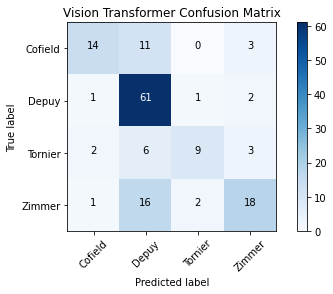

In [ ]:
cm = confusion_matrix(test_label, vit_pred2)
import itertools
# Reference: https://deeplizard.com/learn/video/km7pxKy4UHU
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Vision Transformer Confusion Matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
plot_confusion_matrix(cm,['Cofield','Depuy','Tornier','Zimmer'])



---
This is the end of the project
